In [243]:
import nltk
import string
import warnings
import nltk
import joblib
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

nltk.download("punkt")
nltk.download("stopwords")

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [227]:
df = pd.read_csv('TurkishSMSCollection.csv', sep=";")
df = df[["Message", "GroupText"]]
df.rename(columns={"Message": "text", "GroupText": "label"}, inplace=True)
df.head()

,text,label
0,125 lira,Normal
1,Baskanin aksam toplantısi fenaymis :),Normal
2,Bilal yalçnlara ne zaman gidiyoruz?,Normal
3,"BiP ile mesajlarimi aninda, daha eglenceli gon...",Spam
4,DIGITURKTEN FIRSAT! SiZE OZEL YIL SONUNA KADAR...,Spam


In [228]:
df['label'].value_counts()

Spam      2536
Normal    2215
Name: label, dtype: int64

In [225]:
def find_length(text):
    return len(text)

array([[<AxesSubplot: title={'center': 'length'}>]], dtype=object)

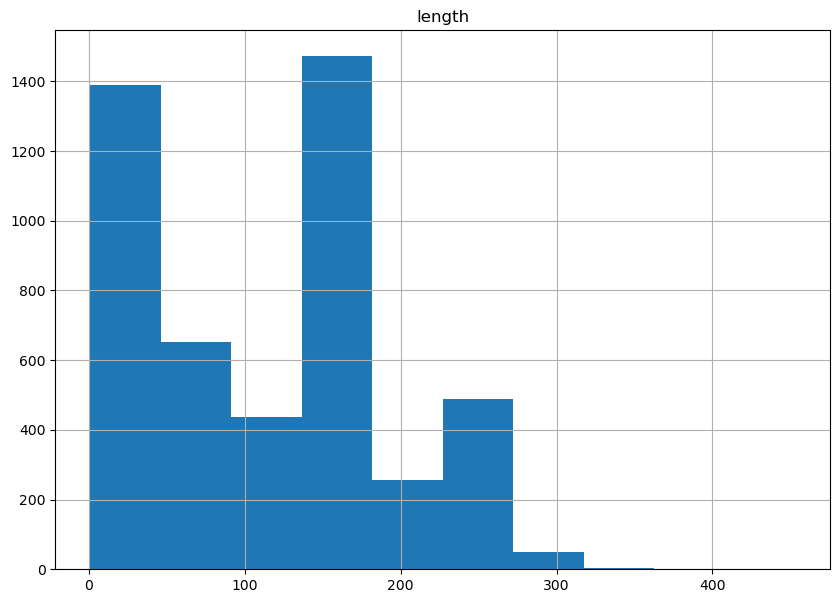

In [229]:
df['length'] = df['text'].apply(find_length)
df.hist(column='length', figsize=(10,7))

In [230]:
stopwords_list = stopwords.words('turkish')

def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [word for word in words if not word in stopwords_list]
    text = " ".join(words)
    return text

In [231]:
df['text'] = df['text'].apply(preprocess_text)

In [143]:
def word_freq(CATEGORY, df):
    freq_df = df[df['label'] == CATEGORY]
    freq_words = freq_df['text'].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []
    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)
    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)
    freq_top = freq_freq.most_common(15)
    
    words = [word for word, _ in freq_top]
    counts = [counts for _, counts in freq_top]
    
    plt.bar(words, counts)
    plt.title(f"{CATEGORY} SINIFINDAKI EN SIK GECEN 15 KELIME")
    plt.rcParams['figure.figsize'] = (20,5)
    plt.ylabel("Frekans")
    plt.xlabel("Kelimeler")
    plt.show()

    return freq_top

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


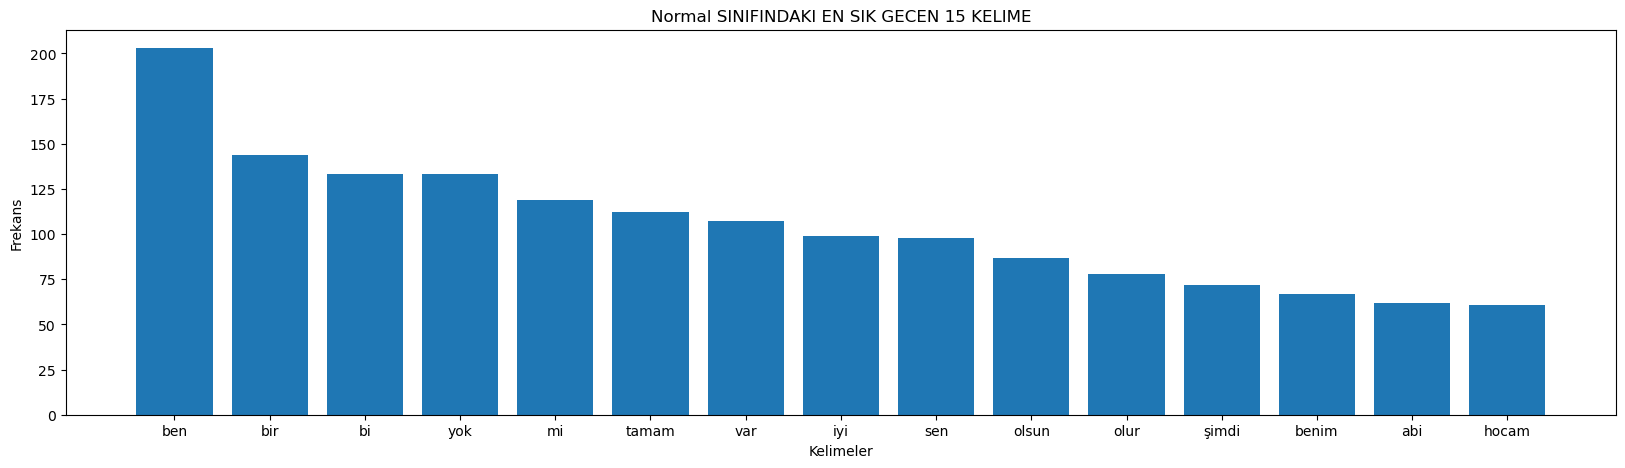

In [232]:
normal_freq = word_freq('Normal', df)

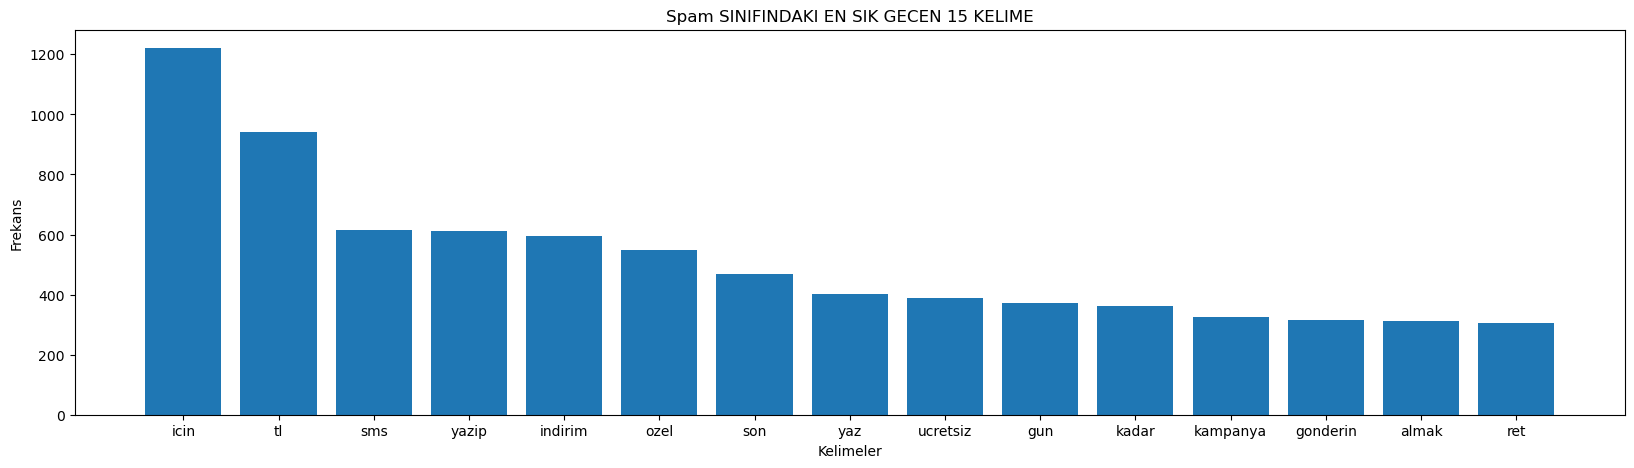

In [233]:
spam_freq = word_freq('Spam', df)

In [234]:
le = LabelEncoder().fit(df["label"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["label"] = df["label"].apply(lambda x: le_nm[x])

In [235]:
df.head(10)

,text,label,length
0,125 lira,0,8
1,Baskanin aksam toplantısi fenaymis,0,37
2,Bilal yalçnlara zaman gidiyoruz,0,35
3,BiP mesajlarimi aninda eglenceli gonderiyorum ...,1,99
4,DIGITURKTEN FIRSAT SiZE OZEL YIL SONUNA KADAR ...,1,157
5,İyi dokuz eylül iyidir arşgör falan kovala,0,49
6,İyiyim teşekkürler oturuyoruz nazarda arkadaşl...,0,106
7,Kapatamıyorun ayarlara girmem lazım,0,39
8,Menüye girsem görünür,0,34
9,Önemli değil hocam iyi akşamlar,0,35


In [249]:
X = df['text']
y = df['label']

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=4242)

# XGBoost 

In [165]:
xgb_model = XGBClassifier().fit(X_train, y_train)

In [166]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9726603575184016

In [ ]:
xgb_params = {'n_estimators': [100, 250, 500],
              'subsample': [0.8, 1.0],
              'max_depth': [3, 5, 10],
              'learning_rate': [0.01, 0.1, 0.2],
}
xgb_model = XGBClassifier()
xgb_cv_model = GridSearchCV(xgb_model, xgb_params, cv=10, n_jobs=-1).fit(X_train, y_train)
xgb_cv_model.best_params_

In [175]:
xgb_tuned = RandomForestClassifier(max_depth=10, max_features=50, n_estimators=500).fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       433
           1       0.99      0.96      0.98       518

    accuracy                           0.97       951
   macro avg       0.97      0.98      0.97       951
weighted avg       0.97      0.97      0.97       951



# SVC

In [177]:
xvc_model = SVC().fit(X_train, y_train)

In [178]:
y_pred = xvc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9779179810725552

In [180]:
svc_params = {"C": np.arange(1, 5)}
svc = SVC(kernel="sigmoid")
svc_cv_model = GridSearchCV(svc, svc_params, cv=10, n_jobs=-1).fit(X_train, y_train)
svc_cv_model.best_params_

{'C': 2}

In [181]:
svc_tuned = SVC(kernel="sigmoid", C=2).fit(X_train, y_train)
y_pred = svc_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       433
           1       0.99      0.98      0.99       518

    accuracy                           0.98       951
   macro avg       0.98      0.98      0.98       951
weighted avg       0.98      0.98      0.98       951



# KNeigbors

In [182]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)

In [183]:
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9221871713985279

In [184]:
knn_params = {"n_neighbors": np.arange(1, 100)}
knn = KNeighborsClassifier()
knn_cv_model = GridSearchCV(knn, knn_params, cv=10).fit(X_train, y_train)
knn_cv_model.best_params_

{'n_neighbors': 7}

In [187]:
knn_tuned = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       433
           1       0.95      0.93      0.94       518

    accuracy                           0.94       951
   macro avg       0.93      0.94      0.94       951
weighted avg       0.94      0.94      0.94       951



# Logistic Regression

In [188]:
logistic_model = LogisticRegression(solver="liblinear").fit(X_train, y_train)

In [189]:
y_pred = logistic_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9737118822292324

In [190]:
logistic_params = {"penalty": ["l1", "l2"]}
logistic_model = LogisticRegression(solver="liblinear")
logistic_cv_model = GridSearchCV(logistic_model, logistic_params, cv=10).fit(X_train, y_train)
logistic_cv_model.best_params_

{'penalty': 'l2'}

In [191]:
logistic_tuned = LogisticRegression(solver="liblinear", penalty="l2").fit(X_train, y_train)
y_pred = logistic_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       433
           1       1.00      0.95      0.98       518

    accuracy                           0.97       951
   macro avg       0.97      0.98      0.97       951
weighted avg       0.97      0.97      0.97       951



# DecisionTree

In [192]:
cart_model = DecisionTreeClassifier().fit(X_train, y_train)

In [193]:
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9652996845425867

In [194]:
cart_params = {"max_depth": range(1, 5), "min_samples_split": list(range(2, 20))}
cart = DecisionTreeClassifier()
cart_cv_model = GridSearchCV(cart, cart_params, cv=10, n_jobs=-1).fit(X_train, y_train)
cart_cv_model.best_params_

{'max_depth': 4, 'min_samples_split': 10}

In [195]:
cart_tuned = DecisionTreeClassifier(max_depth=4, min_samples_split=10).fit(X_train, y_train)
y_pred = cart_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86       433
           1       0.99      0.74      0.85       518

    accuracy                           0.85       951
   macro avg       0.88      0.87      0.85       951
weighted avg       0.89      0.85      0.85       951



# Random Forest

In [196]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [197]:
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9789695057833859

In [202]:
rf_params = {'max_depth': list(range(1, 5)), 'max_features': [1, 2, 3], 'n_estimators': [25, 35, 50]}
rf_model = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1).fit(X_train, y_train)
rf_cv_model.best_params_

{'max_depth': 4, 'max_features': 3, 'n_estimators': 35}

In [204]:
rf_tuned = RandomForestClassifier(max_depth= 4, max_features= 3, n_estimators= 35).fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       433
           1       0.55      1.00      0.71       518

    accuracy                           0.55       951
   macro avg       0.77      0.50      0.36       951
weighted avg       0.75      0.55      0.39       951



In [237]:
joblib.dump(svc_tuned, 'svc_tuned.pkl')
best = joblib.load('svc_tuned.pkl')
best

SVC(C=2, kernel='sigmoid')

In [218]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

def pred(model, text):
    res = "SPAM" if model.predict(vectorizer.transform([text]))[0] == 1 else "NORMAL"
    return res

In [219]:
pred(best, "%25'ye varan aa aayaz indiaaarimi adL yaz koleksiyonunda basladi!")

'SPAM'

In [250]:
pickle.dump(vectorizer, open("tfidf.pickle", "wb"))

In [251]:
file = open("tfidf.pickle","rb")
vectorizer2 = pickle.load(file)

In [252]:
res2 = "SPAM" if best.predict(vectorizer2.transform([text]))[0] == 1 else "NORMAL"
print(res2)

SPAM
